In [45]:
#Imoorting required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,auc
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter

Copying Train & testfiles


In [46]:
train = pd.read_csv("train_Df64byy.csv")
test = pd.read_csv("test_YCcRUnU.csv")

train_original = train.copy()
test_original = test.copy()

Check for Imbalance data


In [47]:
train['Response'].value_counts()

0    38673
1    12209
Name: Response, dtype: int64

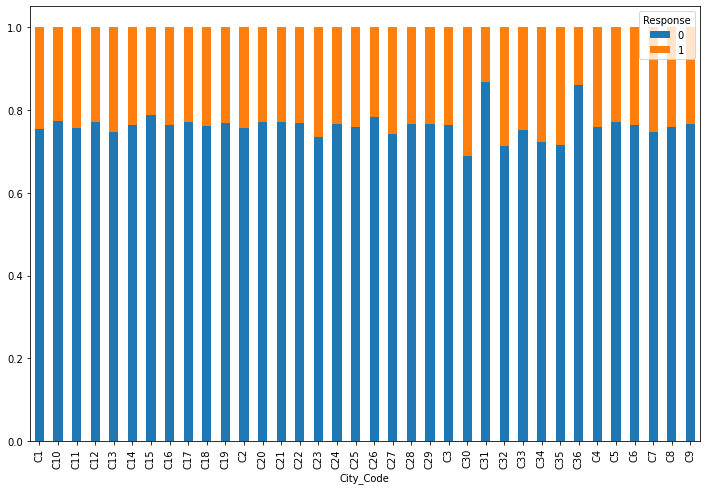

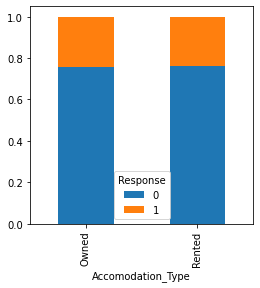

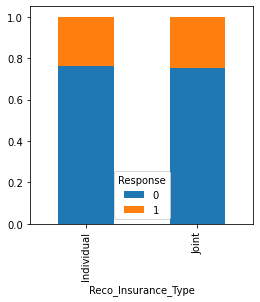

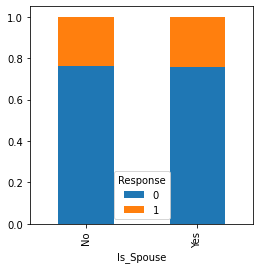

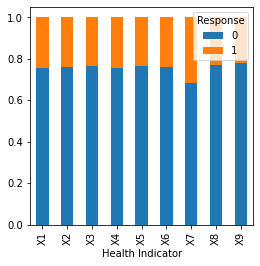

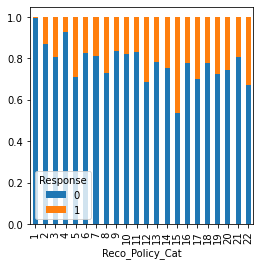

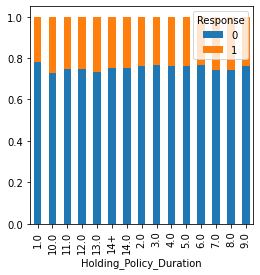

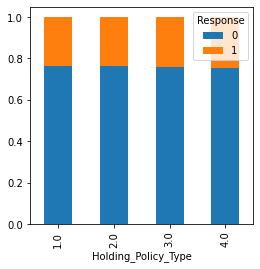

In [48]:
#Visualising the Independent variables on the target
#As this might give the idea as in which are less important in impacting the target


City_code = pd.crosstab(train['City_Code'],train['Response'])
City_code.div(City_code.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (12,8))


Accomodation_Type = pd.crosstab(train['Accomodation_Type'],train['Response'])
Accomodation_Type.div(Accomodation_Type.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Reco_Insurance_Type = pd.crosstab(train['Reco_Insurance_Type'],train['Response'])
Reco_Insurance_Type.div(Reco_Insurance_Type.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Is_Spouse = pd.crosstab(train['Is_Spouse'],train['Response'])
Is_Spouse.div(Is_Spouse.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Health_Indicator = pd.crosstab(train['Health Indicator'],train['Response'])
Health_Indicator.div(Health_Indicator.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Reco_Policy_Cat = pd.crosstab(train['Reco_Policy_Cat'],train['Response'])
Reco_Policy_Cat.div(Reco_Policy_Cat.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Holding_Policy_Duration = pd.crosstab(train['Holding_Policy_Duration'],train['Response'])
Holding_Policy_Duration.div(Holding_Policy_Duration.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))

Holding_Policy_Type = pd.crosstab(train['Holding_Policy_Type'],train['Response'])
Holding_Policy_Type.div(Holding_Policy_Type.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True,figsize = (4,4))


Age factor impact on response being yes or no

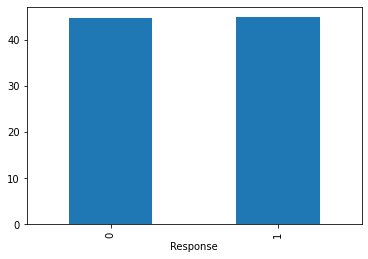

In [49]:
train.groupby('Response')['Upper_Age'].mean().plot.bar()

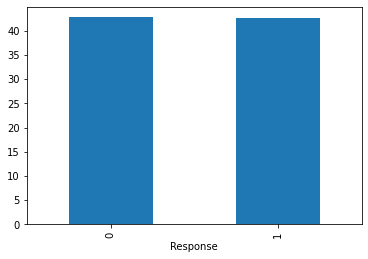

In [50]:
train.groupby('Response')['Lower_Age'].mean().plot.bar()

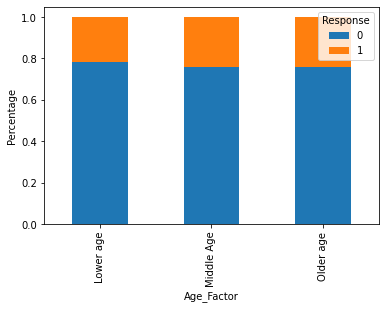

In [51]:
#Creating bins for age factor by considering upper age
bins = [0,20,50,80]
group = ['Lower age','Middle Age','Older age']
train['Age_Factor'] = pd.cut(train['Upper_Age'],bins,labels = group)
test['Age_Factor'] = pd.cut(test['Upper_Age'],bins,labels = group)
Age_Factor = pd.crosstab(train['Age_Factor'],train['Response'])
Age_Factor.div(Age_Factor.sum(1).astype(float),axis = 0).plot(kind="bar",stacked = True)
plt.xlabel('Age_Factor')
P = plt.ylabel('Percentage')

Dropping variables which have not impact the response even slightly

In [52]:
train = train.drop(['Is_Spouse','ID','Lower_Age','Upper_Age','Region_Code','Age_Factor','Holding_Policy_Type','Accomodation_Type','Reco_Insurance_Type'],axis = 1)
test = test.drop(['Is_Spouse','ID','Lower_Age','Upper_Age','Region_Code','Age_Factor','Holding_Policy_Type','Accomodation_Type','Reco_Insurance_Type'],axis = 1)

In [53]:
train.isnull().sum()

City_Code                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [54]:
test.isnull().sum()

City_Code                     0
Health Indicator           5027
Holding_Policy_Duration    8603
Reco_Policy_Cat               0
Reco_Policy_Premium           0
dtype: int64

In [55]:
#Filling missing values
train['Health Indicator'].fillna(train['Health Indicator'].mode()[0],inplace = True)
train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].mode()[0],inplace = True)
#train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].mode()[0],inplace = True)

test['Health Indicator'].fillna(test['Health Indicator'].mode()[0],inplace = True)
test['Holding_Policy_Duration'].fillna(test['Holding_Policy_Duration'].mode()[0],inplace = True)
#test['Holding_Policy_Type'].fillna(test['Holding_Policy_Type'].mode()[0],inplace = True)

PErforming Label encoding

In [56]:
from  sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 

label_encoder = preprocessing.LabelEncoder()

train['Health Indicator']= label_encoder.fit_transform(train['Health Indicator'])
test['Health Indicator']= label_encoder.fit_transform(test['Health Indicator']) 

#train['Accomodation_Type']= label_encoder.fit_transform(train['Accomodation_Type'])
#test['Accomodation_Type']= label_encoder.fit_transform(test['Accomodation_Type'])


#train['Reco_Insurance_Type']= label_encoder.fit_transform(train['Reco_Insurance_Type'])
#test['Reco_Insurance_Type']= label_encoder.fit_transform(test['Reco_Insurance_Type'])

train['City_Code']= label_encoder.fit_transform(train['City_Code'])
test['City_Code']= label_encoder.fit_transform(test['City_Code']) 


In [57]:
train['Holding_Policy_Duration'].replace('14+',14,inplace=True)
test['Holding_Policy_Duration'].replace('14+',14,inplace = True)

In [58]:
train['Holding_Policy_Duration'] = pd.to_numeric(train['Holding_Policy_Duration'])
test['Holding_Policy_Duration'] = pd.to_numeric(train['Holding_Policy_Duration'])

Handling Imabalnce data set using sampling method

In [59]:
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,f1_score
no_response = train[train.Response==0]
response = train[train.Response == 1]

Response_unsampled = resample(response,
                          replace=True, # sample with replacement
                          n_samples=len(no_response), # match number in majority class
                          random_state=27) # reproducible results
unsampled = pd.concat([no_response,Response_unsampled])
unsampled.Response.value_counts()

1    38673
0    38673
Name: Response, dtype: int64

In [60]:
X = unsampled.drop(['Response'],axis = 1)
y = unsampled.Response
x_train,x_cv,y_train,y_cv=train_test_split(X, y, train_size=0.8, stratify = y, random_state=100)

In [61]:
x_train

,City_Code,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium
36204,22,0,1.0,16,11898.0
15309,3,2,1.0,2,4824.0
1544,30,0,1.0,15,4776.0
45895,34,3,7.0,12,8218.0
22994,30,0,1.0,18,5352.0
...,...,...,...,...,...
5143,32,0,7.0,1,17696.0
2675,30,0,1.0,16,15432.0
50227,4,0,12.0,16,14058.0
25421,11,1,1.0,22,21672.0


In [62]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
x_train = Scaler_X.fit_transform(x_train)
x_cv = Scaler_X.transform(x_cv)

In [63]:
#Function to have all performance metrics for classification 
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

def test_eval(clf_model, x_cv, y_cv, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(x_cv)
    y_pred=clf_model.predict(x_cv)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_cv,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_cv,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_cv, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_cv,y_pred))
    recall.append(recall_score(y_cv,y_pred))
    F1score.append(f1_score(y_cv,y_pred))
    AUCROC.append(roc_auc_score(y_cv, y_prob[:,1]))
    resample.append(sampling)

    probs = clf_model.predict_proba(x_cv)
    preds = y_prob[:,1]
    fpr, tpr, threshold = roc_curve(y_cv, preds)
    roc_auc = auc(fpr, tpr)

# method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Model building - early stopping been found out using startified sampling method



In [43]:
xg_model = XGBClassifier(learning_rate=0.5,max_depth = 7, n_estimators=100,early_stopping_rounds = 99)
xg_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=99,
              gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion Matrix
[[5146 2589]
 [1848 5887]] 

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      7735
           1       0.69      0.76      0.73      7735

    accuracy                           0.71     15470
   macro avg       0.72      0.71      0.71     15470
weighted avg       0.72      0.71      0.71     15470
 

AUC-ROC
0.7875321461685963


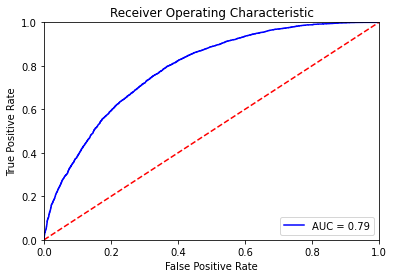

In [64]:
test_eval(xg_model, x_cv, y_cv, 'XGBoost', 'ACTUAL')

In [69]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
test = Scaler_X.fit_transform(test)
pred_test = xg_model.predict(test)

In [70]:
submission  = pd.read_csv("sample_submission_QrCyCoT.csv")
submission['Response'] = pred_test
submission['ID'] = test_original['ID']
submission.head(20)

,ID,Response
0,50883,0
1,50884,0
2,50885,1
3,50886,1
4,50887,0
5,50888,1
6,50889,0
7,50890,1
8,50891,1
9,50892,1


In [71]:
pd.DataFrame(submission,columns=['ID','Response']).to_csv("Health_Insurance.csv",index=False)